In [1]:
# core
import pandas as pd
import numpy as np
import joblib

# Data Preparation utils
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)
from utils.data_preparation import cleaning, create_geoclusters, feature_engineering, encoding, scaling, select_important_variables

# model evaluation
from sklearn.metrics import ConfusionMatrixDisplay

# segmentation
from utils.segmentation import assign_customer_segment


In [2]:
# load complete_df from data
df = pd.read_parquet(
    "../data/initial_dfs/complete_df.parquet",
    engine="pyarrow"
)

In [3]:
df.head(2)

,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Satisfaction Score,Customer Status,Churn Label,Churn Value,Churn Score,CLTV,Churn Category,Churn Reason,ID,Population
Customer ID,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,Los Angeles,...,3,Churned,Yes,1,91,5433,Competitor,Competitor offered more data,21,68701
7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,Los Angeles,...,3,Churned,Yes,1,69,5302,Competitor,Competitor made better offer,54,55668


In [4]:
# execute preprocess: cleaning, create_geocluster, feature_engineering, encoding and scaling

print(f"test initial shape: {df.shape}")

df_proc = cleaning(df)
df_proc = create_geoclusters(df_proc)
df_proc = feature_engineering(df_proc)
df_proc = encoding(df_proc)
df_proc = scaling(df_proc)
df_proc = select_important_variables(df_proc)

print(f"test final shape: {df_proc.shape}")

test initial shape: (7043, 52)
test final shape: (7043, 13)


c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não conseguiu localizar o ficheiro especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pedro\Projects\telco_churn\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __

In [5]:
# split features and target as X and Y
X = df_proc.drop(columns=["Churn Value"])
Y = df_proc["Churn Value"]


In [6]:
# load best model from models/best_lgb_model.pkl
best_model = joblib.load("../models/best_lgb_model.pkl")

In [7]:
# apply model to predict churn and add them as new columns
predictions = best_model.predict(X)
predictions_proba = best_model.predict_proba(X)[:, 1]

df_proc["Churn Prediction"] = predictions
df_proc["Churn Prediction Probability"] = predictions_proba

In [8]:
print(f"shape of df: {df_proc.shape}")
df_proc.head(5)

shape of df: (7043, 15)


,Contract Duration,Dependents,Internet Type,Monthly Charge,Number of Referrals_bins,Paperless Billing,Payment Method_Credit Card,Senior Citizen,Tenure in Months,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Unlimited Data,Churn Value,Churn Prediction,Churn Prediction Probability
Customer ID,,,,,,,,,,,,,,,
8779-QRDMV,0.0,0.0,0.0,-0.564857,0.0,0.0,0.0,1.0,-0.608696,20.0,-0.842008,-1.0,1.0,1.0,0.939481
7495-OOKFY,0.0,1.0,0.5,0.189512,0.5,0.0,1.0,1.0,-0.456522,0.0,0.954938,0.0,1.0,1.0,0.801267
1658-BYGOY,0.0,1.0,0.5,0.461822,0.0,0.0,0.0,1.0,-0.239130,0.0,-0.425235,0.0,1.0,1.0,0.912297
4598-XLKNJ,0.0,1.0,0.5,0.517939,0.5,0.0,0.0,1.0,-0.086957,0.0,-0.115137,0.0,1.0,1.0,0.736728
4846-WHAFZ,0.0,1.0,0.5,0.113155,0.5,0.0,0.0,1.0,0.173913,0.0,-0.609159,0.0,1.0,1.0,0.871220


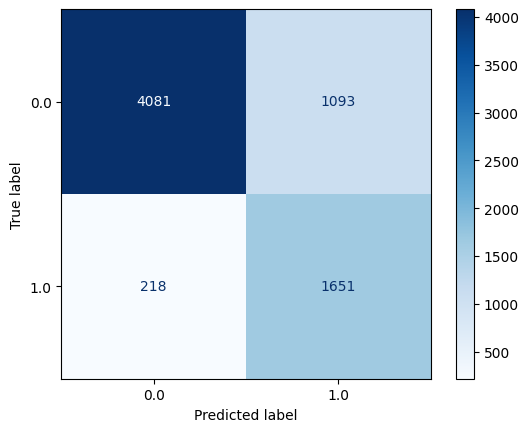

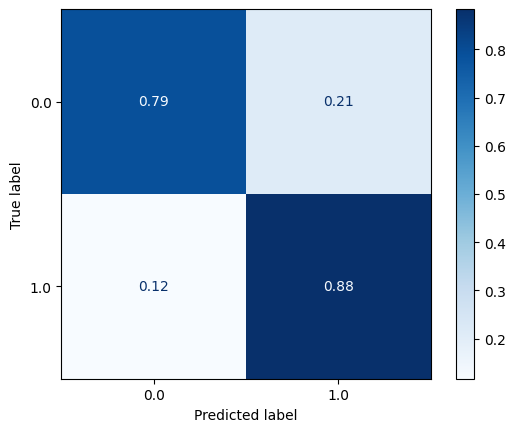

In [9]:
# plot 2 confusion matrix as subplots: one not normalized and other normalized
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    Y,
    predictions,
    cmap="Blues",
    normalize=None,
    values_format=".0f"
)

ConfusionMatrixDisplay.from_predictions(
    Y,
    predictions,
    cmap="Blues",
    normalize="true",
    values_format=".2f"
)

In [10]:
# join df_proc['Churn Prediction'] and df_proc['Churn Prediction Probability'] to original df on index
df_final = df.join(
    df_proc[["Churn Prediction", "Churn Prediction Probability"]],
    how="left"
)

In [11]:
# assign customer segments to df_final using assign_customer_segment function
df_final = assign_customer_segment(df_final)

print(f"shape of final df: {df_final.shape}")
df_final.head(5)

shape of final df: (7043, 61)


,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,City,...,Population,Total Charges per Month,Total Refunds per Month,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Total Revenue per Month,Number of Referrals_bins,Churn Prediction,Churn Prediction Probability,segment
Customer ID,,,,,,,,,,,,,,,,,,,,,
8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,Los Angeles,...,68701,39.650000,0.000000,20.0,0.00,59.650000,0,1.0,0.939481,New Customer
7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,Los Angeles,...,55668,79.162500,0.000000,0.0,48.85,128.012500,1,1.0,0.801267,+65y
1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,Los Angeles,...,47534,97.363889,2.533889,0.0,11.33,106.160000,0,1.0,0.912297,+65y
4598-XLKNJ,Female,78,No,Yes,Yes,Yes,1,United States,California,Inglewood,...,27778,100.580000,0.537200,0.0,19.76,119.802800,1,1.0,0.736728,+65y
4846-WHAFZ,Female,80,No,Yes,Yes,Yes,1,United States,California,Whittier,...,26265,77.517568,0.000000,0.0,6.33,83.847568,1,1.0,0.871220,+65y


In [12]:
# save df_final to data/final_dfs/df_final.parquet
df_final.to_parquet("../data/final_dfs/df_final.parquet")

In [13]:
# Create X with model features and preprocess and save it in data/final_dfs/X.parquet
df_final.to_parquet("../data/final_dfs/df_final.parquet")

print(f"df_final shape: {df_final.shape}")

X = df_final.drop(columns=["segment"])
X = cleaning(X)
X = create_geoclusters(X)
X = feature_engineering(X)
X = encoding(X)
X = scaling(X)
X = select_important_variables(X)

print(f"X shape: {X.shape}")

X.to_parquet("../data/final_dfs/X.parquet")

df_final shape: (7043, 61)


X shape: (7043, 13)


In [14]:
X.head(2)

,Contract Duration,Dependents,Internet Type,Monthly Charge,Number of Referrals_bins,Paperless Billing,Payment Method_Credit Card,Senior Citizen,Tenure in Months,Total Extra Data Charges per Month,Total Long Distance Charges per Month,Unlimited Data,Churn Value
Customer ID,,,,,,,,,,,,,
8779-QRDMV,0.0,0.0,0.0,-0.564857,0.0,0.0,0.0,1.0,-0.608696,20.0,-0.842008,-1.0,1.0
7495-OOKFY,0.0,1.0,0.5,0.189512,0.5,0.0,1.0,1.0,-0.456522,0.0,0.954938,0.0,1.0
